# Are some train routes more likely to experience delays than others? Visualize and proof statistically.

Load in data

In [65]:
import src.data_processing.data as data
import numpy as np
import pandas as pd

Explore the dataset to see if there are outliers regarding the delay time

In [66]:
trips = data.full_trips
trips[["Delay time"]].describe()

Delay time
count  440943.000000
mean      122.892338
std       350.910273
min         0.000000
25%         0.000000
50%        31.000000
75%       123.000000
max     24536.000000

In [103]:
trips.sort_values(by = "Delay time" , ascending = False)

Unnamed: 0 Date of departure  Train number Relation Railway operators  \
18913       18913        2020-09-25          3836    IC 25         SNCB/NMBS   
58796       58796        2020-09-21          2626    IC 08         SNCB/NMBS   
21666       21666        2020-09-24          3610    IC 29         SNCB/NMBS   
52705       52705        2020-09-23           588     L 02         SNCB/NMBS   
58792       58792        2020-09-21          2633    IC 08         SNCB/NMBS   
...           ...               ...           ...      ...               ...   
42352       42352        2020-09-21           324      INT         SNCB/NMBS   
1335         1335        2020-09-21           324      INT         SNCB/NMBS   
42349       42349        2020-09-21           324      INT         SNCB/NMBS   
61013       61013        2020-09-22          3485     L B7         SNCB/NMBS   
9689         9689        2020-09-22          1785   L B1-1         SNCB/NMBS   

      Railway of departure Time of real arrival Time of real departure  \
18913                  NaN  2020-09-25 16:20:50                    NaT   
58796                   35                  NaT    2020-09-21 04:38:03   
21666                   36  2020-09-24 13:42:52    2020-09-24 13:42:52   
52705                   53  2020-09-23 16:48:45    2020-09-23 16:49:15   
58792                   35                  NaT    2020-09-21 11:38:09   
...                    ...                  ...                    ...   
42352                   37  2020-09-21 14:54:16    2020-09-21 14:54:16   
1335                    37  2020-09-21 14:46:53    2020-09-21 14:49:16   
42349                   37  2020-09-21 14:42:47    2020-09-21 14:42:47   
61013                  NaN  2020-09-22 21:20:16                    NaT   
9689                   NaN  2020-09-22 21:19:56                    NaT   

      Time of planned arrival Time of planned departure  \
18913     2020-09-25 16:21:00                       NaT   
58796                     NaT       2020-09-21 04:36:00   
21666     2020-09-24 13:43:00       2020-09-24 13:43:00   
52705     2020-09-23 16:49:00       2020-09-23 16:49:00   
58792                     NaT       2020-09-21 11:36:00   
...                       ...                       ...   
42352     2020-09-21 09:16:00       2020-09-21 09:16:00   
1335      2020-09-21 08:56:00       2020-09-21 09:11:00   
42349     2020-09-21 08:50:00       2020-09-21 08:50:00   
61013     2020-09-22 14:36:00                       NaT   
9689      2020-09-22 14:31:00                       NaT   

                        Direction of relation Name of the stop  \
18913      IC 25: LIEGE-SAINT-LAMBERT -> MONS             mons   
58796    IC 08: HASSELT -> ANTWERPEN-CENTRAAL          hasselt   
21666      IC 29: GENT-SINT-PIETERS -> LANDEN      erps-kwerps   
52705      L 02: MECHELEN -> ZEEBRUGGE-STRAND         malderen   
58792    IC 08: HASSELT -> ANTWERPEN-CENTRAAL          hasselt   
...                                       ...              ...   
42352           INT: WIEN HBF -> BRUSSEL-ZUID  dolhain-gileppe   
1335            INT: WIEN HBF -> BRUSSEL-ZUID      welkenraedt   
42349           INT: WIEN HBF -> BRUSSEL-ZUID       hergenrath   
61013                 L B7: MECHELEN -> HALLE        vilvoorde   
9689   L B1-1: ANTWERPEN-CENTRAAL -> NIVELLES        vilvoorde   

      Railway of arrival Date of planned arrival Date of planned departure  \
18913                118              2020-09-25                       NaT   
58796                NaN                     NaT                2020-09-21   
21666                 36              2020-09-24                2020-09-24   
52705                 53              2020-09-23                2020-09-23   
58792                NaN                     NaT                2020-09-21   
...                  ...                     ...                       ...   
42352                 37              2020-09-21                2020-09-21   
1335                  37       

We delete all delay times > 85.000 seconds, which is equal to almost 24 hours and thus can be seen as 'impossible'.

In [68]:

trips = data.full_trips
for x in trips[['Delay time']]:
    trips.loc[trips[x] > 85000,x] = np.nan
trips[["Delay time"]].describe()

Delay time
count  440943.000000
mean      122.892338
std       350.910273
min         0.000000
25%         0.000000
50%        31.000000
75%       123.000000
max     24536.000000

We assume that a train route is an array of subsequent train stops

In [69]:
train_numbers = trips["Train number"].unique()
#routes is a dictionary that takes the train number as key and returns all the subsequent stop this train has passed through
routes = {}
for train_number in train_numbers:
    routes[train_number] = trips[trips["Train number"] == train_number].sort_values(by= [ "Time of real departure"])

In [70]:
#routes_by_day does the same as routes, but groups it by date of departure
routes_by_day = {}
for train_number in train_numbers:
    routes_by_day[train_number] = [group for _, group in routes[train_number].groupby("Date of departure")]


In [71]:
print(len(routes_by_day.get(10))) # for example this train rode on 7 different days
print(len(routes_by_day.get(12))) # while this one only rode on 6 different days

7
6


We can calculate the percentage of delays per day, per route

In [72]:
percentage_of_delays = {}
for train_number in train_numbers:
    percentage_of_delays[train_number] = []
    for day in routes_by_day.get(train_number):
        percentage_of_delays.get(train_number).append(day[day["Delay time"] > 0].shape[0] / day.shape[0])

On the first day, all stops of the route experienced a delay, the second day only 10% of the stops had a delay etc.

In [73]:
percentage_of_delays.get(10)

[1.0, 0.1, 0.25, 1.0, 1.0, 0.85, 0.0]

Indeed we see that for 2020-09-20, every stop had a Delay time >0

In [74]:
routes.get(10)[routes.get(10)["Date of departure"] == "2020-09-20"][["Date of departure", "Delay time"]]

Date of departure  Delay time
13572        2020-09-20       450.0
13575        2020-09-20       470.0
14842        2020-09-20       463.0
14845        2020-09-20       425.0
14848        2020-09-20       354.0
14851        2020-09-20       240.0
14854        2020-09-20       183.0
14042        2020-09-20       132.0
14857        2020-09-20       132.0
14860        2020-09-20       132.0
13578        2020-09-20       165.0
14045        2020-09-20       199.0
14048        2020-09-20       211.0
13581        2020-09-20       235.0
14863        2020-09-20       213.0
14051        2020-09-20       196.0
14866        2020-09-20       195.0
14054        2020-09-20       205.0
13584        2020-09-20       203.0
14057        2020-09-20       186.0

Now we can calculate the average percentage of delays per route

In [75]:
average_percentage_of_delays = {}
for train_number in train_numbers:
    average_percentage_of_delays[train_number] = sum(percentage_of_delays.get(train_number)) / len(percentage_of_delays.get(train_number))

On average, 60% of the stops of route 10 experience delays.

In [76]:
average_percentage_of_delays.get(10)

0.6

We put this dictionary in a dataframe and add the direction of relation, so we can get a better indication of the route

In [80]:
average_percentage_of_delays_df = pd.DataFrame.from_dict(average_percentage_of_delays, orient ="index").reset_index().rename(columns = {"index": "Route", 0: "Delay_frequency"})
average_percentage_of_delays_df["Direction of relation"]  = average_percentage_of_delays_df.reset_index()["Route"].apply(lambda x: routes.get(x)["Direction of relation"].iloc[0])
average_percentage_of_delays_df

Route  Delay_frequency                     Direction of relation
0        11         0.816667  ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1       116         0.380952                IC 33: LIERS -> LUXEMBOURG
2       110         0.585034                IC 33: LIERS -> LUXEMBOURG
3       112         0.435374                IC 33: LIERS -> LUXEMBOURG
4       113         0.551020                IC 33: LUXEMBOURG -> LIERS
...     ...              ...                                       ...
4362  17204         0.941176                                       NaN
4363  17206         0.928571                                       NaN
4364  17209         0.975000                                       NaN
4365   9372         0.500000           THAL:BRUSSEL-ZUID -> PARIS-NORD
4366  12685         0.250000                                       NaN

[4367 rows x 3 columns]

Descriptive analysis

In [87]:
average_percentage_of_delays_df["Delay_frequency"].describe()

count    4367.000000
mean        0.606082
std         0.211340
min         0.000000
25%         0.500000
50%         0.640674
75%         0.754637
max         1.000000
Name: Delay_frequency, dtype: float64

We plot a histogram of the "Delay_frequency"

<AxesSubplot: ylabel='Frequency'>

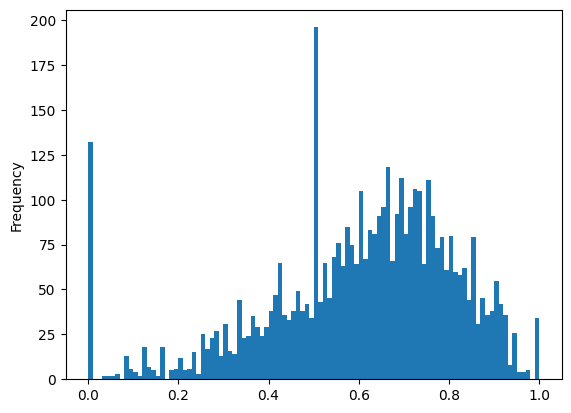

In [82]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(bins = 100)

Now we plot the same thing but cumulatively

<AxesSubplot: ylabel='Frequency'>

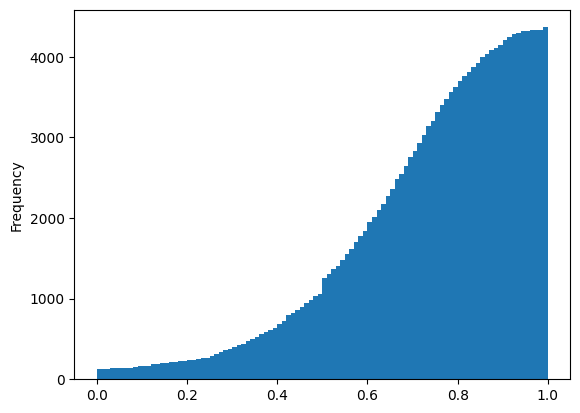

In [83]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(cumulative = True, bins = 100)

Intriguing that train routes that have a delay frequency of 100% are not considered outliers (the train is always late in this route).


In [90]:
def get_outlier(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    outlier = df[(df[column] > q3 + 1.5 * iqr) | (df[column] < q1 - 1.5 * iqr)]
    return outlier

outliers = get_outlier(average_percentage_of_delays_df, "Delay_frequency")
outliers


Route  Delay_frequency                  Direction of relation
66     4068         0.033333       L 31: JURBISE -> BRAINE-LE-COMTE
76     4081         0.033333       L 31: BRAINE-LE-COMTE -> JURBISE
88     4080         0.066667       L 31: BRAINE-LE-COMTE -> JURBISE
94     4083         0.100000       L 31: BRAINE-LE-COMTE -> JURBISE
305   19714         0.095238    IC 04-2: KORTRIJK -> LILLE FLANDRES
...     ...              ...                                    ...
4254  19212         0.000000         IC 42: QUEVY-FRONTIERE -> MONS
4323  12743         0.090909                                    NaN
4351  19706         0.000000    IC 04-2: KORTRIJK -> LILLE FLANDRES
4352  19705         0.000000    IC 04-2: LILLE FLANDRES -> KORTRIJK
4355   9382         0.052632  THAL:AMSTERDAM CENTRAAL -> PARIS-NORD

[166 rows x 3 columns]

All non-outliers are thus more likely to experience delays

In [99]:
def get_diff(df1, df2):
    return df1.merge(df2, indicator=True, how='outer').loc[lambda x : x['_merge']=='left_only']
more_likely_to_experience_delays = get_diff(average_percentage_of_delays_df, outliers).drop(columns=['_merge'])
more_likely_to_experience_delays

Route  Delay_frequency                             Direction of relation
0        11         0.816667          ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1       116         0.380952                        IC 33: LIERS -> LUXEMBOURG
2       110         0.585034                        IC 33: LIERS -> LUXEMBOURG
3       112         0.435374                        IC 33: LIERS -> LUXEMBOURG
4       113         0.551020                        IC 33: LUXEMBOURG -> LIERS
5      2083         0.613445                    L B10-1: AALST -> BRUSSEL-ZUID
6      2092         0.714286                    L B10-1: AALST -> BRUSSEL-ZUID
7      2437         0.703448        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
8      2086         0.638655                    L B10-1: AALST -> BRUSSEL-ZUID
9      2105         0.821053               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
10     2090         0.657143                    L B10-1: AALST -> BRUSSEL-ZUID
11     1706         0.865897              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
12     1712         0.485185              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
13      111         0.578231                        IC 33: LUXEMBOURG -> LIERS
14     1708         0.585403              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
15     2107         0.638913               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
16     2091         0.546218                    L B10-1: AALST -> BRUSSEL-ZUID
17     1941         0.566834   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
18     2080         0.571429                    L B10-1: AALST -> BRUSSEL-ZUID
19     1538         0.827403                       IC 03: GENK -> BLANKENBERGE
20     1939         0.675797   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
21     2089         0.654342                    L B10-1: AALST -> BRUSSEL-ZUID
22     1539         0.842688                       IC 03: GENK -> BLANKENBERGE
23     2106         0.869453               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
24       17         0.814286          ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
25     1943         0.597625   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
26     1536         0.535084                       IC 03: GENK -> BLANKENBERGE
27     1710         0.614815              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
28     1940         0.770295   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
29     1540         0.723946                       IC 03: GENK -> BLANKENBERGE
30     2093         0.529412                    L B10-1: AALST -> BRUSSEL-ZUID
31     1705         0.733333              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
32     1532         0.728714                       IC 03: GENK -> BLANKENBERGE
33     1692         0.457143                        L 36: ZOTTEGEM -> KORTRIJK
34     1711         0.528540              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
35     2081         0.588235                    L B10-1: AALST -> BRUSSEL-ZUID
36     2439         0.837931        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
37      117         0.394558                        IC 33: LUXEMBOURG -> LIERS
38     2082         0.605042                    L B10-1: AALST -> BRUSSEL-ZUID
39     2104         0.686667               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
40     2084         0.579832                    L B10-1: AALST -> BRUSSEL-ZUID
41     1535         0.700629                       IC 03: GENK -> BLANKENBERGE
42     1533         0.855282                       IC 03: GENK -> BLANKENBERGE
43     2438         0.737931        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
44     2088         0.579832                    L B10-1: AALST -> BRUSSEL-ZUID
45     1691         0.742857                        L 36: ZOTTEGEM -> KORTRIJK
46     1942         0.447607   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
47     2440         0.662963        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
48     1694         0.600000                        L 36: ZOTTEGEM -> KORTRIJK
49     1531         0.855658                       IC 03

We can also look at the p-value

In [101]:

import scipy.stats as stats
def calculate_z_score(df, column):
    df["z_score"] = (df[column] - df[column].mean()) / df[column].std(ddof=0)
    return df
def calculate_p_value(df):
    df["p_value"] = stats.norm.sf(abs(df["z_score"])) * 2
    return df

calculate_z_score(average_percentage_of_delays_df, "Delay_frequency")
calculate_p_value(average_percentage_of_delays_df)
average_percentage_of_delays_df

Route  Delay_frequency  \
0        11         0.816667   
1       116         0.380952   
2       110         0.585034   
3       112         0.435374   
4       113         0.551020   
5      2083         0.613445   
6      2092         0.714286   
7      2437         0.703448   
8      2086         0.638655   
9      2105         0.821053   
10     2090         0.657143   
11     1706         0.865897   
12     1712         0.485185   
13      111         0.578231   
14     1708         0.585403   
15     2107         0.638913   
16     2091         0.546218   
17     1941         0.566834   
18     2080         0.571429   
19     1538         0.827403   
20     1939         0.675797   
21     2089         0.654342   
22     1539         0.842688   
23     2106         0.869453   
24       17         0.814286   
25     1943         0.597625   
26     1536         0.535084   
27     1710         0.614815   
28     1940         0.770295   
29     1540         0.723946   
30     2093         0.529412   
31     1705         0.733333   
32     1532         0.728714   
33     1692         0.457143   
34     1711         0.528540   
35     2081         0.588235   
36     2439         0.837931   
37      117         0.394558   
38     2082         0.605042   
39     2104         0.686667   
40     2084         0.579832   
41     1535         0.700629   
42     1533         0.855282   
43     2438         0.737931   
44     2088         0.579832   
45     1691         0.742857   
46     1942         0.447607   
47     2440         0.662963   
48     1694         0.600000   
49     1531         0.855658   
50     2085         0.722689   
51     1709         0.681481   
52     1704         0.565280   
53     1693         0.700000   
54     1707         0.874074   
55     1537         0.712078   
56     2087         0.613445   
57     2856         0.571429   
58     1534         0.701710   
59     2464         0.290909   
60     3603         0.638710   
61     4268         0.600000   
62     3607         0.791947   
63     2860         0.197802   
64     3880         0.561224   
65     3611         0.655025   
66     4068         0.033333   
67     4085         0.200000   
68     2457         0.418182   
69     4087         0.333333   
70     2843         0.318127   
71     4265         0.637755   
72     3219         0.637003   
73     4486         0.875000   
74     2854         0.430769   
75     3883         0.602041   
76     4081         0.033333   
77     2463         0.218182   
78     3220         0.230144   
79     3608         0.688499   
80     2867         0.338828   
81     4261         0.596939   
82     4482         0.675000   
83     3610         0.662900   
84     3878         0.806122   
85     2443         0.478194   
86     4070         0.266667   
87     2866         0.417582   
88     4080         0.066667   
89     4069         0.300000   
90     4086         0.700000   
91     4485         0.607143   
92     2458         0.345455   
93     3226         0.300000   
94     4083         0.100000   
95     4084         0.233333   
96     3615         0.614005   
97     3884         0.632653   
98     2441         0.658621   
99     4487         0.750000   
100    4076         0.300000   
101    2861         0.384615   
102    3609         0.644313   
103    2844         0.632653   
104    4079         0.266667   
105    2842         0.517007   
106    4082         0.166667   
107    4264         0.557143   
108    3876         0.842857   
109    3877         0.900000   
110    3612         0.710070   
111    3882         0.795918   
112    3879         0.857143   
113    2862         0.439560   
114    4267         0.627551   
115    2855         0.292308   
116    2863         0.230769   
117    2865         0.230769   
118    4077         0.660000   
119    4262         0.642857   
120    2858         0.373626   
121    2456         0.400000   
122    4483         0.696429   
123     426         0.406689   
124   

These routes are less likely to experience delays

In [102]:
 average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05]

Route  Delay_frequency  \
66     4068         0.033333   
76     4081         0.033333   
88     4080         0.066667   
94     4083         0.100000   
106    4082         0.166667   
243    2914         0.145788   
305   19714         0.095238   
324   19719         0.133333   
329   19718         0.095238   
347    2941         0.187546   
358   19726         0.095238   
381   19716         0.000000   
382   19720         0.047619   
475   19744         0.000000   
518   19743         0.142857   
654   19915         0.166667   
921    4443         0.185714   
1036   1522         0.000000   
1082   5084         0.000000   
1086   5083         0.000000   
1092   5081         0.000000   
1095   7496         0.066667   
1097   5089         0.000000   
1103   5088         0.000000   
1104   5082         0.000000   
1106   5085         0.000000   
1108   5092         0.000000   
1115   5091         0.000000   
1116   5087         0.000000   
1125   5093         0.000000   
1131   5080         0.000000   
1133   5090         0.000000   
1159   5079         0.000000   
1161   5086         0.000000   
1251   8066         0.000000   
1268   8067         0.066667   
1306   4731         0.000000   
1323   7655         0.000000   
1327   7656         0.000000   
1331   4716         0.000000   
1335   5181         0.139683   
1336   4730         0.000000   
1364   7657         0.000000   
1393   4711         0.166667   
1404   5809         0.000000   
1412   5808         0.000000   
1424   5807         0.000000   
1434   5811         0.000000   
1440   4748         0.000000   
1453   5806         0.000000   
1595   5918         0.000000   
1603   5917         0.000000   
1613   5905         0.000000   
1615   5907         0.000000   
1621   5916         0.000000   
1625   5909         0.000000   
1638   8487         0.083333   
1640   5908         0.000000   
1642   5912         0.000000   
1651   5904         0.000000   
1662   5906         0.000000   
1684   4607         0.000000   
1686   4609         0.000000   
1689   4615         0.000000   
1711   4608         0.000000   
1738   8641         0.000000   
1787   4628         0.000000   
1846   4629         0.000000   
1856   4063         0.133333   
1869   4065         0.000000   
1900   4066         0.166667   
1999   4064         0.166667   
2121   4089         0.100000   
2161   2931         0.139194   
2277  19737         0.190476   
2280  19736         0.133333   
2285  19728         0.095238   
2287  19730         0.142857   
2301  19734         0.190476   
2311  19741         0.111111   
2313  19735         0.095238   
2316  19739         0.047619   
2342  19742         0.133333   
2352  19740         0.133333   
2741   2327         0.180000   
2901   1521         0.142857   
2948   4645         0.000000   
2957   5060         0.000000   
2965   5072         0.000000   
2978   8645         0.000000   
2990   5064         0.000000   
2998   4644         0.000000   
3001   8646         0.000000   
3036   5063         0.166667   
3043   4643         0.000000   
3045   8776         0.150000   
3091   8777         0.000000   
3092   5096         0.000000   
3120   5097         0.000000   
3124   5095         0.000000   
3135   8058         0.120000   
3145   5098         0.000000   
3216   4742         0.000000   
3223   4744         0.000000   
3229   7608         0.000000   
3232   4705         0.166667   
3234   4736         0.000000   
3245   4733         0.000000   
3249   7606         0.000000   
3259   4746         0.000000   
3260   4747         0.000000   
3264   4734         0.000000   
3265   4739         0.000000   
3270   4732         0.000000   
3288   4745         0.000000   
3294   4735         0.000000   
3300   4738         0.000000   
3303   4740         0.000000   
3305   4741         0.000000   
3310   4743         0.000000   
3311   4737         0.000000   
3376   5819         0.000000   
3377   5814         0.000000   
3388   5817         0.000000   
3389  

# We can also set a threshold of 60 seconds before something will be counted as a delay.

Now we will see a lot more reasonable results

In [117]:
percentage_of_delays = {}
for train_number in train_numbers:
    percentage_of_delays[train_number] = []
    for day in routes_by_day.get(train_number):
        # change the day["Delay time"] > x value
        percentage_of_delays.get(train_number).append(day[day["Delay time"] > 59].shape[0] / day.shape[0])

average_percentage_of_delays = {}
for train_number in train_numbers:
    average_percentage_of_delays[train_number] = sum(percentage_of_delays.get(train_number)) / len(percentage_of_delays.get(train_number))

average_percentage_of_delays_df = pd.DataFrame.from_dict(average_percentage_of_delays,
                                                         orient="index").reset_index().rename(
    columns={"index": "Route", 0: "Delay_frequency"})
average_percentage_of_delays_df["Direction of relation"] = average_percentage_of_delays_df.reset_index()["Route"].apply(
    lambda x: routes.get(x)["Direction of relation"].iloc[0])
average_percentage_of_delays_df


Route  Delay_frequency                             Direction of relation
0        11         0.500000          ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
1       116         0.122449                        IC 33: LIERS -> LUXEMBOURG
2       110         0.326531                        IC 33: LIERS -> LUXEMBOURG
3       112         0.217687                        IC 33: LIERS -> LUXEMBOURG
4       113         0.258503                        IC 33: LUXEMBOURG -> LIERS
5      2083         0.075630                    L B10-1: AALST -> BRUSSEL-ZUID
6      2092         0.285714                    L B10-1: AALST -> BRUSSEL-ZUID
7      2437         0.496552        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
8      2086         0.176471                    L B10-1: AALST -> BRUSSEL-ZUID
9      2105         0.617544               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
10     2090         0.249300                    L B10-1: AALST -> BRUSSEL-ZUID
11     1706         0.773305              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
12     1712         0.166667              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
13      111         0.265306                        IC 33: LUXEMBOURG -> LIERS
14     1708         0.293028              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
15     2107         0.483304               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
16     2091         0.142857                    L B10-1: AALST -> BRUSSEL-ZUID
17     1941         0.274555   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
18     2080         0.159664                    L B10-1: AALST -> BRUSSEL-ZUID
19     1538         0.666158                       IC 03: GENK -> BLANKENBERGE
20     1939         0.360544   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
21     2089         0.242577                    L B10-1: AALST -> BRUSSEL-ZUID
22     1539         0.681785                       IC 03: GENK -> BLANKENBERGE
23     2106         0.727665               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
24       17         0.457143          ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF
25     1943         0.295322   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
26     1536         0.242485                       IC 03: GENK -> BLANKENBERGE
27     1710         0.344444              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
28     1940         0.536735   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
29     1540         0.549620                       IC 03: GENK -> BLANKENBERGE
30     2093         0.142857                    L B10-1: AALST -> BRUSSEL-ZUID
31     1705         0.377778              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
32     1532         0.543619                       IC 03: GENK -> BLANKENBERGE
33     1692         0.114286                        L 36: ZOTTEGEM -> KORTRIJK
34     1711         0.236166              IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS
35     2081         0.126050                    L B10-1: AALST -> BRUSSEL-ZUID
36     2439         0.637931        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
37      117         0.115646                        IC 33: LUXEMBOURG -> LIERS
38     2082         0.109244                    L B10-1: AALST -> BRUSSEL-ZUID
39     2104         0.313333               IC 16-1: BRUSSEL-ZUID -> LUXEMBOURG
40     2084         0.134454                    L B10-1: AALST -> BRUSSEL-ZUID
41     1535         0.454573                       IC 03: GENK -> BLANKENBERGE
42     1533         0.645769                       IC 03: GENK -> BLANKENBERGE
43     2438         0.555172        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
44     2088         0.252101                    L B10-1: AALST -> BRUSSEL-ZUID
45     1691         0.342857                        L 36: ZOTTEGEM -> KORTRIJK
46     1942         0.179854   IC 06-1: BRUSSELS AIRPORT - ZAVENTEM -> TOURNAI
47     2440         0.518519        IC 18: LIEGE-SAINT-LAMBERT -> BRUSSEL-ZUID
48     1694         0.050000                        L 36: ZOTTEGEM -> KORTRIJK
49     1531         0.715432                       IC 03

In [118]:
average_percentage_of_delays_df["Delay_frequency"].describe()

count    4367.000000
mean        0.344652
std         0.216009
min         0.000000
25%         0.187500
50%         0.331868
75%         0.489403
max         1.000000
Name: Delay_frequency, dtype: float64

<AxesSubplot: ylabel='Frequency'>

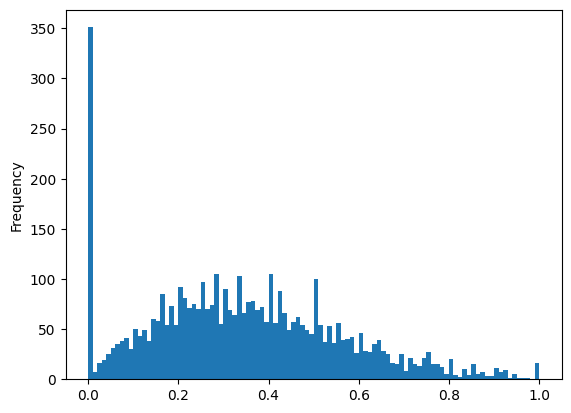

In [119]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(bins = 100)

<AxesSubplot: ylabel='Frequency'>

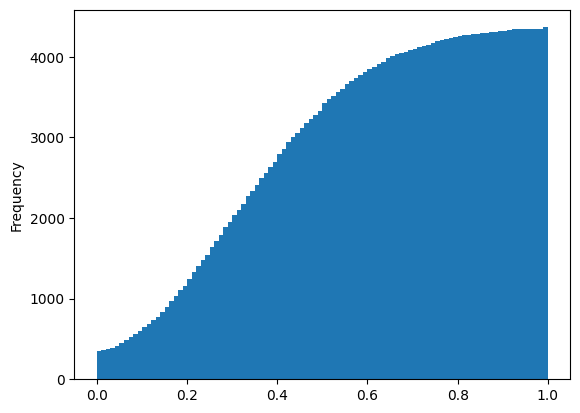

In [120]:
average_percentage_of_delays_df["Delay_frequency"].plot.hist(cumulative = True, bins = 100)

In [121]:
average_percentage_of_delays_df.describe()

Route  Delay_frequency
count   4367.000000      4367.000000
mean    5255.034578         0.344652
std     4182.633734         0.216009
min       10.000000         0.000000
25%     2477.500000         0.187500
50%     4161.000000         0.331868
75%     6492.500000         0.489403
max    19979.000000         1.000000

Now we see that the higher delay_frequency are considered abnormal

In [122]:
import scipy.stats as stats
def calculate_z_score(df, column):
    df["z_score"] = (df[column] - df[column].mean()) / df[column].std(ddof=0)
    return df
def calculate_p_value(df):
    df["p_value"] = stats.norm.sf(abs(df["z_score"])) * 2
    return df

calculate_z_score(average_percentage_of_delays_df, "Delay_frequency")
calculate_p_value(average_percentage_of_delays_df)
average_percentage_of_delays_df

Route  Delay_frequency  \
0        11         0.500000   
1       116         0.122449   
2       110         0.326531   
3       112         0.217687   
4       113         0.258503   
5      2083         0.075630   
6      2092         0.285714   
7      2437         0.496552   
8      2086         0.176471   
9      2105         0.617544   
10     2090         0.249300   
11     1706         0.773305   
12     1712         0.166667   
13      111         0.265306   
14     1708         0.293028   
15     2107         0.483304   
16     2091         0.142857   
17     1941         0.274555   
18     2080         0.159664   
19     1538         0.666158   
20     1939         0.360544   
21     2089         0.242577   
22     1539         0.681785   
23     2106         0.727665   
24       17         0.457143   
25     1943         0.295322   
26     1536         0.242485   
27     1710         0.344444   
28     1940         0.536735   
29     1540         0.549620   
30     2093         0.142857   
31     1705         0.377778   
32     1532         0.543619   
33     1692         0.114286   
34     1711         0.236166   
35     2081         0.126050   
36     2439         0.637931   
37      117         0.115646   
38     2082         0.109244   
39     2104         0.313333   
40     2084         0.134454   
41     1535         0.454573   
42     1533         0.645769   
43     2438         0.555172   
44     2088         0.252101   
45     1691         0.342857   
46     1942         0.179854   
47     2440         0.518519   
48     1694         0.050000   
49     1531         0.715432   
50     2085         0.336134   
51     1709         0.422222   
52     1704         0.132785   
53     1693         0.300000   
54     1707         0.625926   
55     1537         0.376246   
56     2087         0.218487   
57     2856         0.296703   
58     1534         0.447199   
59     2464         0.200000   
60     3603         0.361290   
61     4268         0.171429   
62     3607         0.531832   
63     2860         0.087912   
64     3880         0.214286   
65     3611         0.238165   
66     4068         0.000000   
67     4085         0.066667   
68     2457         0.381818   
69     4087         0.166667   
70     2843         0.109244   
71     4265         0.326531   
72     3219         0.312489   
73     4486         0.575000   
74     2854         0.323077   
75     3883         0.102041   
76     4081         0.000000   
77     2463         0.145455   
78     3220         0.065072   
79     3608         0.364376   
80     2867         0.136447   
81     4261         0.280612   
82     4482         0.325000   
83     3610         0.351706   
84     3878         0.530612   
85     2443         0.111226   
86     4070         0.033333   
87     2866         0.219780   
88     4080         0.000000   
89     4069         0.033333   
90     4086         0.466667   
91     4485         0.178571   
92     2458         0.254545   
93     3226         0.066667   
94     4083         0.000000   
95     4084         0.133333   
96     3615         0.307290   
97     3884         0.224490   
98     2441         0.372414   
99     4487         0.339286   
100    4076         0.233333   
101    2861         0.153846   
102    3609         0.317771   
103    2844         0.205282   
104    4079         0.000000   
105    2842         0.122449   
106    4082         0.000000   
107    4264         0.314286   
108    3876         0.585714   
109    3877         0.657143   
110    3612         0.258702   
111    3882         0.336735   
112    3879         0.581633   
113    2862         0.219780   
114    4267         0.362245   
115    2855         0.061538   
116    2863         0.054945   
117    2865         0.076923   
118    4077         0.426667   
119    4262         0.242857   
120    2858         0.120879   
121    2456         0.327273   
122    4483         0.410714   
123     426         0.204682   
124   

Routes that go to Brussel zuid, arlon, namur, vilvoorde, tournai : high chance of delay

In [123]:
average_percentage_of_delays_df[average_percentage_of_delays_df["p_value"] <0.05]

Route  Delay_frequency                            Direction of relation  \
11     1706         0.773305             IC 14: QUIEVRAIN -> LIEGE-GUILLEMINS   
196    2128         0.791980              IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID   
208    2129         0.802189              IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID   
220    2133         0.771709              IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID   
234    1555         0.855172                        L B6: AALST -> SCHAARBEEK   
295    2187         0.892308                         L B4: AALST -> VILVOORDE   
318    2179         0.907692                         L B4: AALST -> VILVOORDE   
337    2182         0.892308                         L B4: AALST -> VILVOORDE   
346    2184         0.769231                         L B4: AALST -> VILVOORDE   
356    2186         0.800000                         L B4: AALST -> VILVOORDE   
362    2183         0.784615                         L B4: AALST -> VILVOORDE   
368    2180         0.876923                         L B4: AALST -> VILVOORDE   
375    2178         0.846154                         L B4: AALST -> VILVOORDE   
390   12157         0.786667                                              NaN   
457    3991         0.855556         L B8-1: LOUVAIN-LA-NEUVE -> BRUSSEL-ZUID   
505    4480         0.775000                    L 26: LA LOUVIERE-SUD -> MONS   
741   19945         1.000000               IC 19-2: LILLE FLANDRES -> TOURNAI   
879    2038         0.842973  IC 07: ANTWERPEN-NOORDERDOKKEN -> CHARLEROI-SUD   
917   19201         0.900000                   IC 42: MONS -> QUEVY-FRONTIERE   
925   19223         0.900000                   IC 42: MONS -> QUEVY-FRONTIERE   
1032   8678         1.000000                                              NaN   
1067   8677         1.000000                                              NaN   
1090   7016         0.872941                                              NaN   
1099   6557         0.858824                L B8-4: BRUSSEL-ZUID -> OTTIGNIES   
1113   5565         0.776398                           L 15: LIERS -> MARLOIE   
1248   6591         0.941176                L B8-4: OTTIGNIES -> BRUSSEL-ZUID   
1252   9364         0.789474            THAL:AMSTERDAM CENTRAAL -> PARIS-NORD   
1279   6059         0.769841                         L 11: NAMUR -> LIBRAMONT   
1307   6086         0.811111                         L 11: LIBRAMONT -> NAMUR   
1319   7095         0.800000                                              NaN   
1324   6081         0.774603                         L 11: LIBRAMONT -> NAMUR   
1330   6078         0.811111                         L 11: LIBRAMONT -> NAMUR   
1390   7653         0.916667                                              NaN   
1444   6267         0.783333                         L 08: OTTIGNIES -> NAMUR   
1465   7690         0.775000                                              NaN   
1495   7692         0.800000                                              NaN   
1505    908         0.848505                        IC 19-1: TOURNAI -> NAMUR   
1519   5840         0.800000                        L 12: LUXEMBOURG -> ARLON   
1526   4757         0.816667               L C3: CHARLEROI-SUD -> ERQUELINNES   
1529    907         0.776152                        IC 19-1: TOURNAI -> NAMUR   
1530   5835         0.800000                        L 12: LUXEMBOURG -> ARLON   
1542   5837         1.000000                        L 12: LUXEMBOURG -> ARLON   
1557   5838         0.800000                        L 12: LUXEMBOURG -> ARLON   
1559   7753         0.784615                                              NaN   
1561   7741         0.837151                                              NaN   
1566    530         0.775395                         IC 01: EUPEN -> OOSTENDE   
1591    941         0.771429                        IC 19-1: NAMUR -> TOURNAI   
1614   9412         0.817460                      THAL:KOLN HBF -> PARIS-NORD   
1690   5386         0.789116         

In [124]:
outliers = get_outlier(average_percentage_of_delays_df, "Delay_frequency")
outliers

Route  Delay_frequency                     Direction of relation  \
741   19945         1.000000        IC 19-2: LILLE FLANDRES -> TOURNAI   
1032   8678         1.000000                                       NaN   
1067   8677         1.000000                                       NaN   
1542   5837         1.000000                 L 12: LUXEMBOURG -> ARLON   
2346   3979         0.945029  L B8-1: LOUVAIN-LA-NEUVE -> BRUSSEL-ZUID   
3070   6579         0.943791         L B8-4: OTTIGNIES -> BRUSSEL-ZUID   
3348   5834         1.000000                 L 12: LUXEMBOURG -> ARLON   
3363   5827         1.000000                 L 12: LUXEMBOURG -> ARLON   
3380   5830         1.000000                 L 12: LUXEMBOURG -> ARLON   
3413   5832         1.000000                 L 12: LUXEMBOURG -> ARLON   
4036   4641         1.000000              IC 16-2: LUXEMBOURG -> ARLON   
4124   9334         1.000000     THAL:AMSTERDAM CENTRAAL -> PARIS-NORD   
4150   9891         1.000000      TGV:STRASBOURG-VILLE -> BRUSSEL-ZUID   
4156   8223         0.962963                                       NaN   
4157    891         0.942434                L 28: MECHELEN -> KORTRIJK   
4160   9375         1.000000     THAL:PARIS-NORD -> AMSTERDAM CENTRAAL   
4207  18004         0.958333                                       NaN   
4211   9095         1.000000                                       NaN   
4334  19807         1.000000     IC 41: ERQUELINNES-FRONTIERE -> NAMUR   
4339  19907         1.000000        IC 19-2: LILLE FLANDRES -> TOURNAI   
4356   9603         1.000000            IZY:PARIS-NORD -> BRUSSEL-ZUID   
4364  17209         0.975000                                       NaN   

       z_score   p_value  
741   3.034235  0.002411  
1032  3.034235  0.002411  
1067  3.034235  0.002411  
1542  3.034235  0.002411  
2346  2.779722  0.005441  
3070  2.773989  0.005537  
3348  3.034235  0.002411  
3363  3.034235  0.002411  
3380  3.034235  0.002411  
3413  3.034235  0.002411  
4036  3.034235  0.002411  
4124  3.034235  0.002411  
4150  3.034235  0.002411  
4156  2.862755  0.004200  
4157  2.767707  0.005645  
4160  3.034235  0.002411  
4207  2.841320  0.004493  
4211  3.034235  0.002411  
4334  3.034235  0.002411  
4339  3.034235  0.002411  
4356  3.034235  0.002411  
4364  2.918486  0.003517

In [125]:
routes.get(9095)

Unnamed: 0 Date of departure  Train number Relation Railway operators  \
39096       39096        2020-09-20          9095      TGV         SNCB/NMBS   
39656       39656        2020-09-20          9095      TGV         SNCB/NMBS   

      Railway of departure Time of real arrival Time of real departure  \
39096                    1  2020-09-20 12:14:45    2020-09-20 12:14:45   
39656                  NaN  2020-09-20 12:23:55                    NaT   

      Time of planned arrival Time of planned departure Direction of relation  \
39096     2020-09-20 10:53:00       2020-09-20 10:53:00                   NaN   
39656     2020-09-20 11:01:00                       NaT                   NaN   

                  Name of the stop Railway of arrival Date of planned arrival  \
39096                        halle                  1              2020-09-20   
39656  brussel-zuid/bruxelles-midi                96N              2020-09-20   

      Date of planned departure Date of real arrival Date of real departure  \
39096                2020-09-20           2020-09-20             2020-09-20   
39656                       NaT           2020-09-20                    NaT   

       Delay time  
39096      4905.0  
39656      4975.0